<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 2: Variational Autoencoders
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [1]:
name = 'Alireza FarajTabrizi'
std_id = '403206554'

In [98]:
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [99]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (5 points)

Download the MNIST dataset and merge the train and test datasets for training the generative model.

In [100]:
# TODO: Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Merge the two datasets to train the model on the images.

In [101]:
# TODO: Concatenate train and test datasets
merged_dataset = ConcatDataset((train_dataset, test_dataset))
merged_loader = DataLoader(merged_dataset, batch_size=128, shuffle=True)

print(f'The size of the merged dataset is {len(merged_loader.dataset)}')

The size of the merged dataset is 70000


Plot the distribution of each class in the dataset.

# EDA (10 points)

In [102]:
def plot_class_distribution(dataloader):
    # TODO: Initialize a dictionary to count occurrences of each class
    class_count = {i:0 for i in range(10)}
    
    # TODO: Iterate through the DataLoader to count the labels
    for _, labels in dataloader:
        for l in labels:
            class_count[l.item()]+=1

    # TODO: Plot the histogram
    keys = list(class_count.keys())
    values = list(class_count.values())

    plt.bar(keys, values, edgecolor='black')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.xticks(keys)  
    plt.show()
    pass

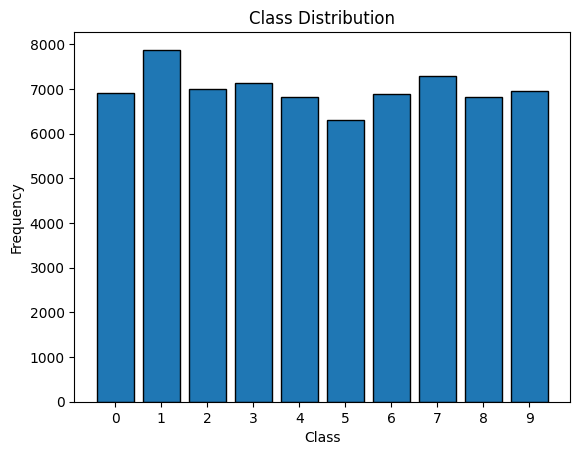

In [103]:
plot_class_distribution(merged_loader)

Plot the average of each class in the dataset.

In [104]:
def plot_class_averages(dataloader):
    # TODO: Iterate over the DataLoader to accumulate sums and counts
    initial_image = torch.zeros(next(iter(merged_loader))[0][0].shape)
    class_avg = {i:initial_image.clone() for i in range(10)}
    class_count = {i:0 for i in range(10)}
    
    for images, labels in dataloader:
        for img, l in zip(images, labels):
            class_count[l.item()]+=1
            class_avg[l.item()]+=img
    # TODO: Calculate the average images for each class
    for i in range(10):
        class_avg[i] = class_avg[i]/class_count[i]
    # TODO: Plot the averages
    plt.figure(figsize = (14,5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.title(f"Class {i}")
        plt.axis("off")
        plt.imshow(class_avg[i].permute(1,2,0).cpu().numpy(), cmap="gray")
    plt.show()

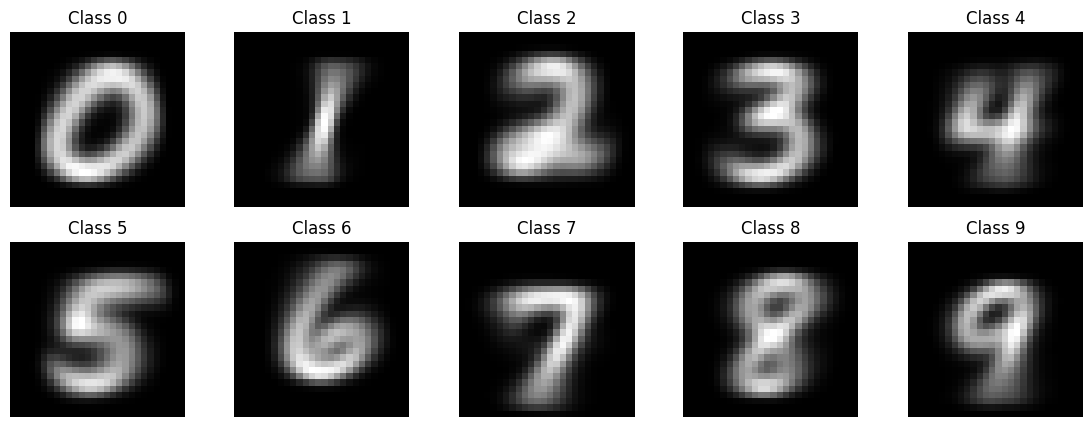

In [105]:
plot_class_averages(merged_loader)

# Variational Autoencoder (25 points)

In [277]:
class VAE(nn.Module):

    def __init__(self, latent_dim=2):
        # TODO
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_size = 28 * 28 * 1
        self.hidden_size1 = 256
        self.hidden_size2 = 128
        
        self.flatten = nn.Flatten()
        
        self.dnn_phi = nn.Sequential(
            nn.Linear(self.input_size, self.hidden_size1),
            nn.ReLU(),
            nn.Linear(self.hidden_size1, self.hidden_size2),
            nn.ReLU(),
            nn.Linear(self.hidden_size2, 2 * latent_dim) 
        )

        self.dnn_theta = nn.Sequential(
            nn.Linear(latent_dim, self.hidden_size2),
            nn.ReLU(),
            nn.Linear(self.hidden_size2, self.hidden_size1),
            nn.ReLU(),
            nn.Linear(self.hidden_size1, self.input_size),
            nn.Sigmoid()
        )
        

    def encode(self, x):
        # TODO
        x = self.flatten(x)
        x = self.dnn_phi(x)

        mean_z = x [...,:self.latent_dim]
        log_var_z = x[...,self.latent_dim:]
        return mean_z, log_var_z

    def reparameterization(self, mean, var):
        # TODO
        eps = torch.randn_like(mean).to(device)
        z = mean + var * eps
        return z
        

    def decode(self, x):
        # TODO
        x = self.dnn_theta(x)
        return x
    
    def forward(self, x):
        # TODO
        mean_z, log_var_z = self.encode(x)
        std_z = torch.exp(0.5 * log_var_z)
        z = self.reparameterization(mean_z, std_z)
        x_hat = self.decode(z)
        return x_hat, mean_z, log_var_z

In [290]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

# Training (20 points)

Define the loss function for training the VAE. The loss functions should be a combination of the reconstruction loss and the KL-divergence loss. You can choose to increase the weight of these losses to achieve better results.

In [291]:
def loss_function(x, x_hat, mean, log_var):
    # TODO
    alpha = 0.9
    BCE = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = 0.5 * torch.sum(mean.pow(2) + log_var.exp() - (1 + log_var))
    loss = alpha * BCE + (1-alpha) * KLD
    return loss

Now you must train your network using the loss function you defined earlier. Make sure to plot and monitor the training loss over epochs.

In [292]:
def plot_losses(losses):
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("VAE Training Loss")
    plt.show()
    pass


def train(model, optimizer, n_epochs=50, losses=losses):
    # TODO
    model.train()
    for epoch in trange(n_epochs):
        epoch_loss = 0 
        for x, _ in merged_loader:  
            x = x.to(device)
            
            optimizer.zero_grad()
            x_hat, mean_z, log_var_z = model(x)
            
            loss = loss_function(x.reshape(x.shape[0],-1), x_hat, mean_z, log_var_z)
            epoch_loss += loss.item()
            
            loss.backward()
            optimizer.step()
        
        average_epoch_loss = epoch_loss / len(merged_loader.dataset)
        losses.append(average_epoch_loss)
        
    print(f"Final Loss: {average_epoch_loss:.6f}")
    plot_losses(losses)
    return losses

100%|██████████| 50/50 [08:41<00:00, 10.44s/it]

Final Loss: 116.639559


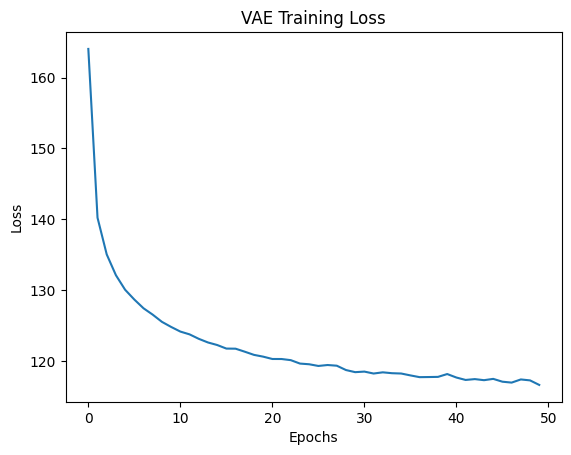

In [293]:
losses = train(model, optimizer, losses=losses)
torch.save(model, "best_VAE.pth")

# The Encoder (20 points)

Let's first take a look at the encoder. Start by visualizing the latent dimension for the merged dataset.

In [294]:
def visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the dataloader and plot the latent space
    z_space = []
    z_label = []

    for i, (x,y) in enumerate(dataloader):
        z = model.encode(x.to(device))[0].detach().cpu().numpy()
        z_space.append(z)
        z_label.append(y.cpu().numpy())
        if i == batch_count:
            break
    
    z_space = np.concatenate(z_space)
    z_label = np.concatenate(z_label)
    plt.figure(figsize = (12,8))
    plt.scatter(z_space[:, 0], z_space[:, 1], c=z_label, cmap= plt.get_cmap('jet', 10))
    plt.colorbar()
    plt.title(title)

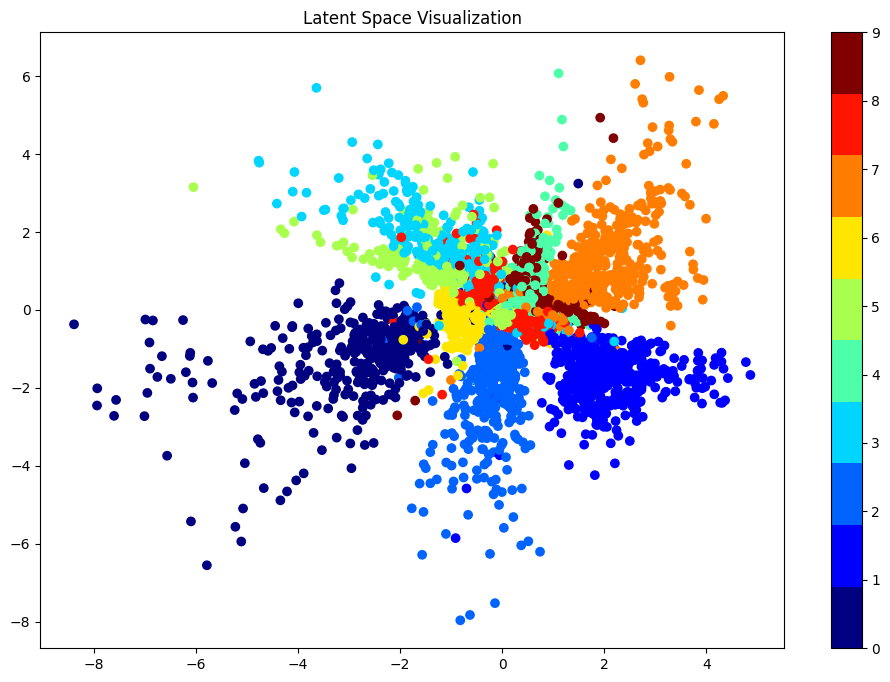

In [295]:
visualize(model, merged_loader)

Imagine if the input data for the encoder followed a very different distribution. Invert the images in the original datset and plot the latent dimension once more to show the difference.

In [296]:
def inverted_visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the inverted dataloader and plot the latent space
    z_space = []
    z_label = []

    for i, (x,y) in enumerate(dataloader):
        x = 1 - x
        z = model.encode(x.to(device))[0].detach().cpu().numpy()
        z_space.append(z)
        z_label.append(y.cpu().numpy())
        if i == batch_count:
            break
    
    z_space = np.concatenate(z_space)
    z_label = np.concatenate(z_label)
    plt.figure(figsize = (12,8))
    plt.scatter(z_space[:, 0], z_space[:, 1], c=z_label, cmap= plt.get_cmap('jet', 10))
    plt.colorbar()
    plt.title(title)

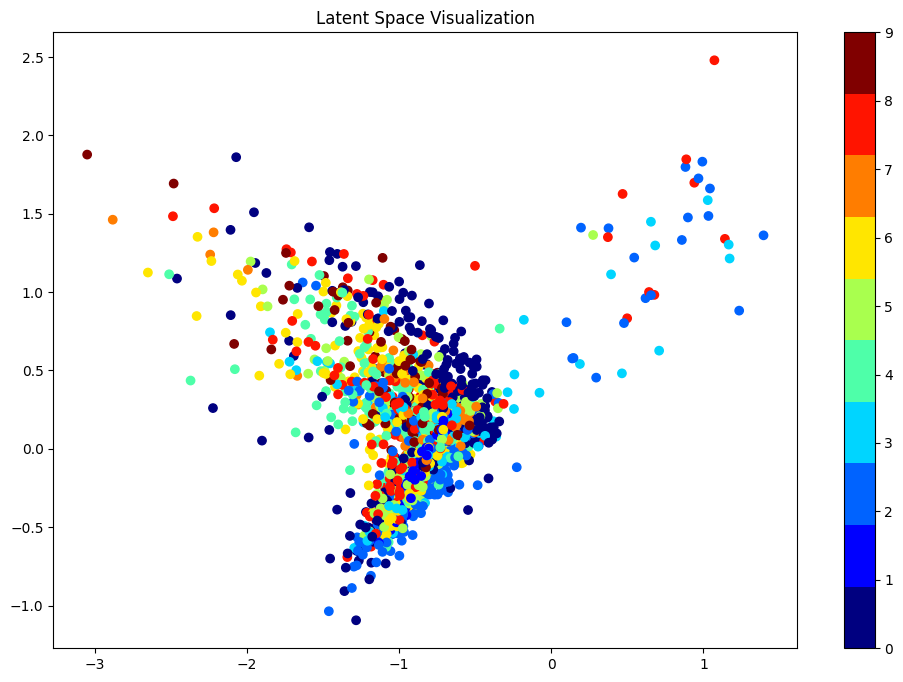

In [297]:
inverted_visualize(model, merged_loader)

Explain how the difference in the latent dimension allows us to detect data samples that don't follow the original distribution. How can this difference be used for anomaly detection? If we had used an autoencoder instead, what would be our observation then?

*`Your Answer:`*

# The Decoder (20 points)

In this section we are going to test the properties of the decoder. First implement a function to create samples based on the input mean and variance.

In [298]:
def generate_digit(mean, var):
    epsilon = torch.randn_like(mean).to(device)
    
    z_sample = mean + var*epsilon
    x_hat = model.decode(z_sample)
    img = x_hat.detach().cpu().numpy().reshape(1,28, 28)
    return img

Now using this function plot the decoded output sampled from a uniform distribution from -1 to +1.

In [299]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # TODO: Display a n*n 2D manifold of digits and construct a grid
    latent_image = np.zeros((n*digit_size, n*digit_size))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)
    
    # TODO: Generate images for the grid
    for i, x in enumerate(grid_x):
        for j, y in enumerate(grid_y):
            z = torch.Tensor([x, y]).to(device)
            x_hat = model.decode(z)
            latent_image[j*digit_size : (j+1)*digit_size, (n-1-i)*digit_size : (n-i)*digit_size] = x_hat.detach().cpu().reshape(1,28, 28)
    
    # TODO: Display the results
    r = (-scale, scale, -scale, scale)
    plt.figure(figsize = (18,15))
    plt.imshow(latent_image, extent=r, cmap='gray')
    plt.title('VAE Latent Space Visualization')
    plt.xlabel('z [0]')
    plt.ylabel('z [1]')

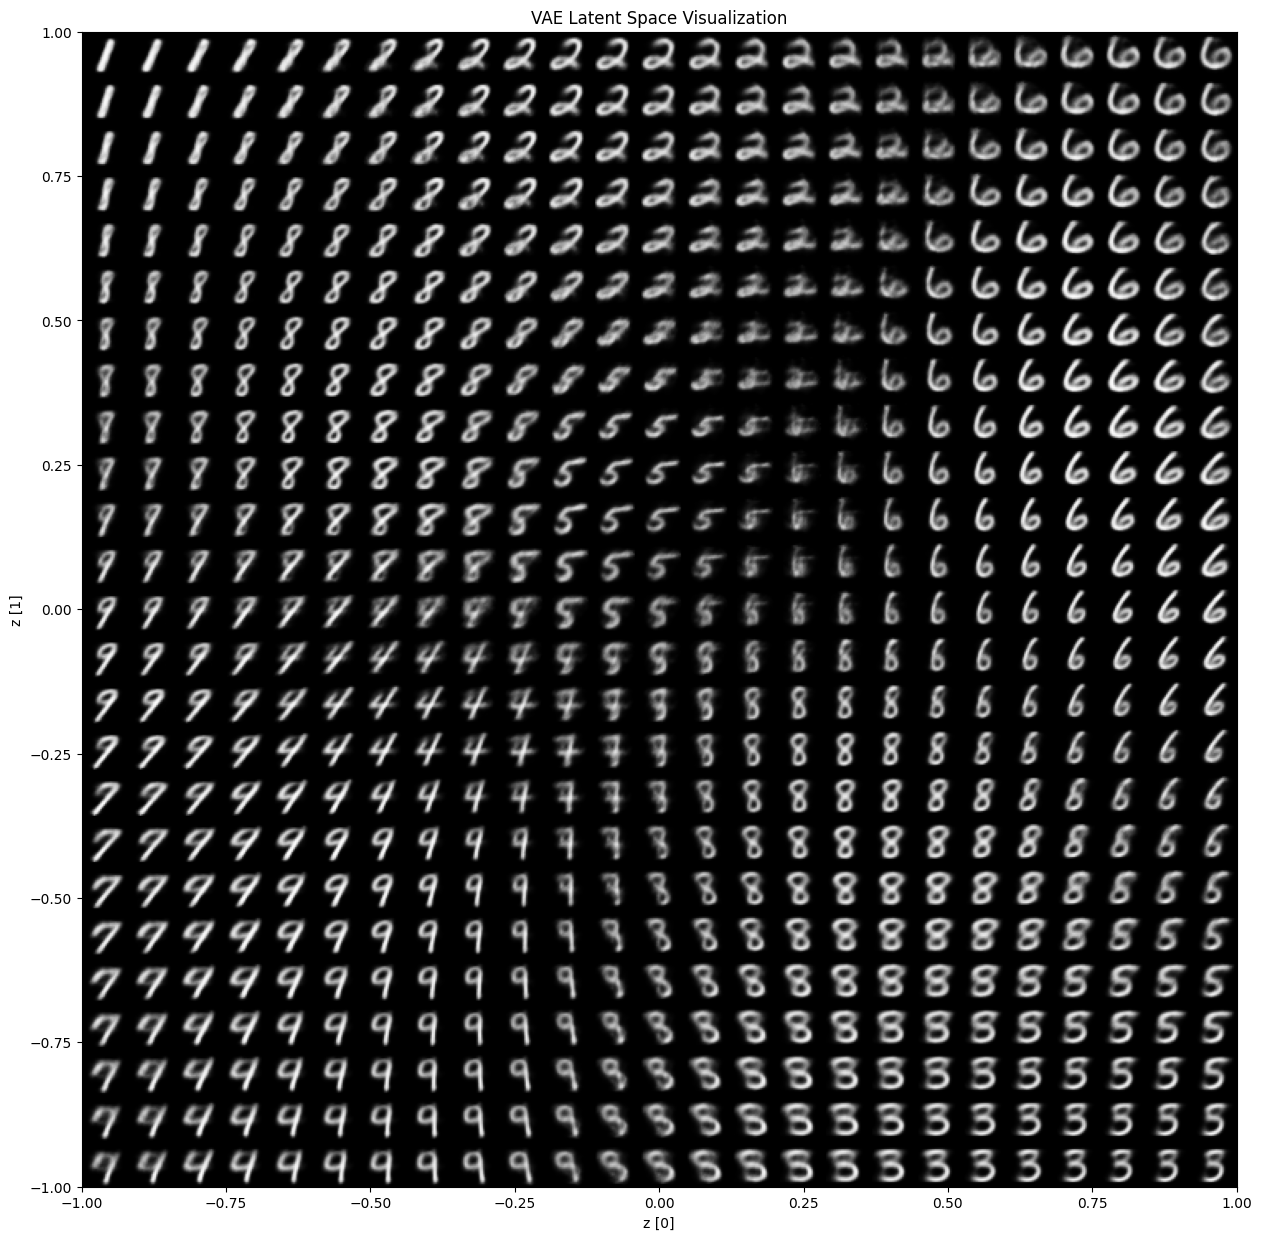

In [300]:
plot_latent_space(model)

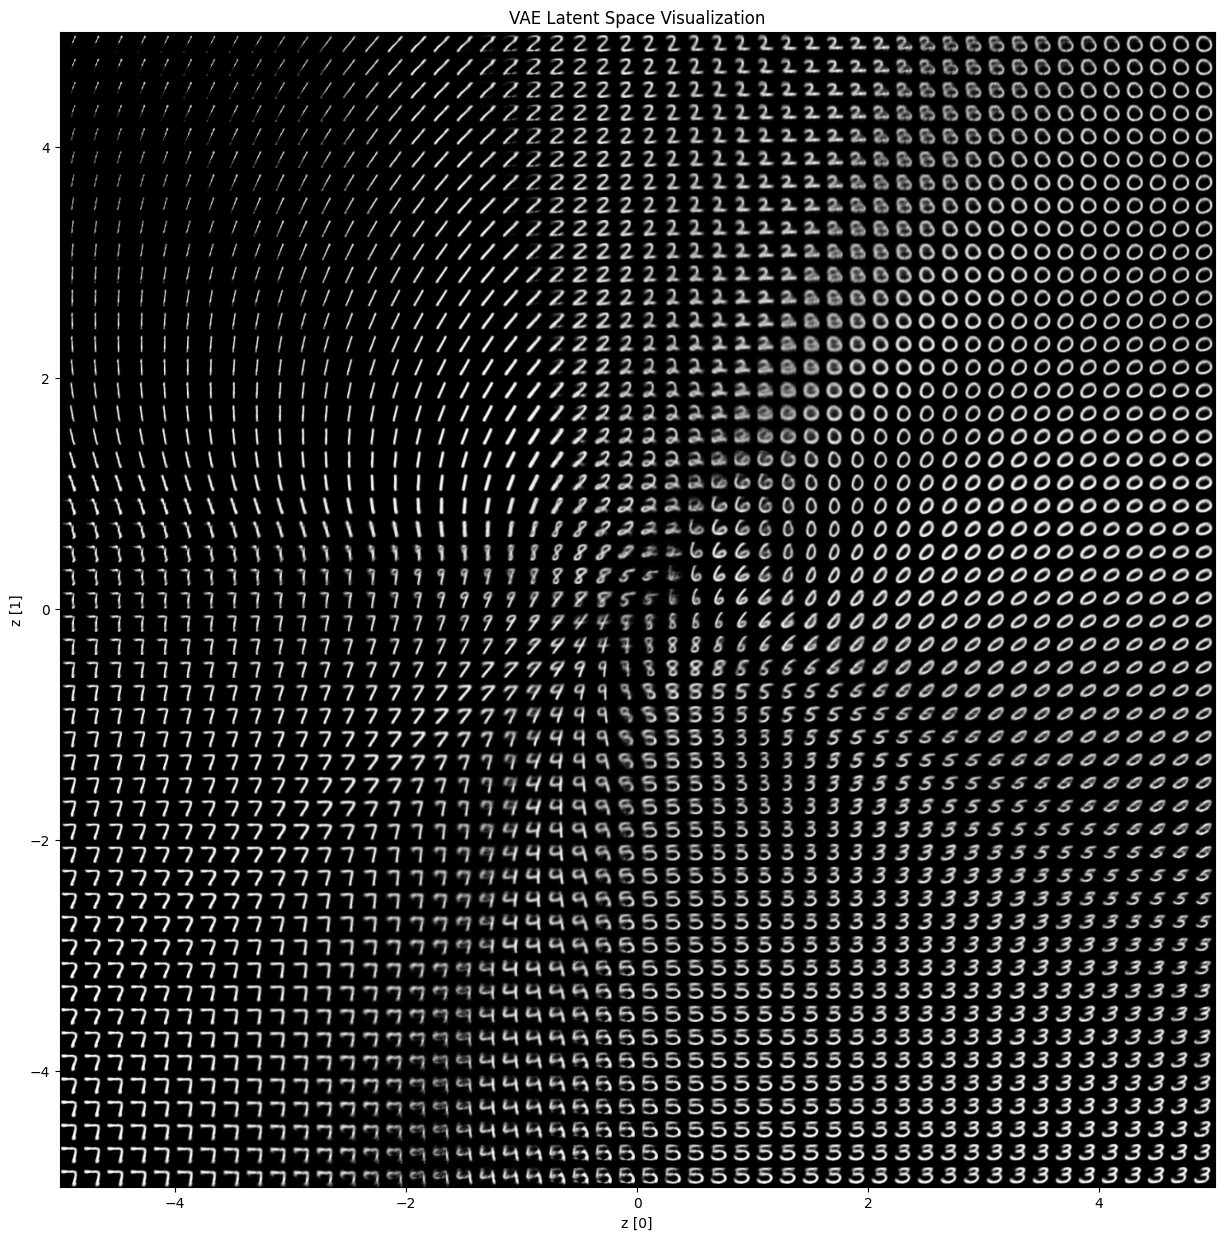

In [301]:
plot_latent_space(model, scale=5, n=50)

What happens when you sample from regions outside the aformentioned space? Why? What could we expect if the network was not a variational autoencoder, but a simple autoencoder instead?

*`Your Answer:`*

As you can see, as you move farther from the mean, the images converge to a specific digit, but their quality decreases.
This happens because the KLD component of the loss function encourages the model to map meaningful data latents to a standard normal distribution, N(0,1). Therefore, the closer z is to the mean of N(0,1), the better the quality of the generated image is.
If it was simple AE then there was no force on Model Trainin Phase to learn a meaningful latent space and as a result the random z samples could end up with random noises.
